# Whale Classification from echo-location clicks

The task is simplified by the fact that whales usually occur in groups all belonging to the same species. The clicks can be separated into “runs” of clicks, each usually corresponding to a single species, separated by periods without clicks.

The classification was done by hand by Professor Hildebrand and became the basis for an estimate of the numbers of animals present at these sites. These results were presented in: Hildebrand, J. A., Baumann-Pickering, S., Frasier, K. E., Trickey, J. S., Merkens, K. P., Wiggins, S. M., McDonald, M. A., Garrison, L. P., Harris, D., Marques, T. A., and Thomas, L. (2015). "Passive acoustic monitoring of beaked whale densities in the Gulf of Mexico," Scientific Reports 5, 16343.

The goal of the proposed project is to create a classifier that takes as input data a run of clicks and outputs the species that is found in that run.

Beyond this project, there are many potential follow-up projects, related to analyzing various sounds emitted by marine mammals, including songs of baleen whales.

Peta-bytes of underwater audio data have been collected by Scripps and other oceanographic institutions, and the systematic analysis of these data is in it’s infancy. There is many opportunities for people with the relevant skills in big data analysis and signal processing to get involved in the process of discovering the information contained in sound and other oceanographic data.

In [91]:
import numpy as np
import matplotlib.pyplot as plt


import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.pandas as ps


In [182]:
conf = pyspark.SparkConf()
conf.setAppName('pandas_api')
conf.set('spark.executor.memory', '2g')
conf.set("spark.driver.memory", "2g")
conf.setMaster('local[2]')  # 8 cores of my 12 CPU threads
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true") # Force arrow
conf.set("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") # better bug tracing

try: 
    print("Running Spark session stopped")
    sc.stop()
except: 
    print("No Running Spark session to stop")
    pass


sc = pyspark.SparkContext(conf=conf).getOrCreate()
spark = SparkSession(sc)

Running Spark session stopped


## The Dataset
The full dataset has 6.5 million clicks with data of the size of about 27GB. After filtering the mis-classified clicks and faulty data, we end up with 4.1 million clicks of which 1.9 million are Gervais and 2.2 million are Cuviers.

Here we use a sample of about 15MB in size that contains about 2000 samples from each species.

In [183]:
file_data = np.load("/home/zenbook/Documents/code/python/uc_san_diego_master/4_semester/4_decision_trees/XGBoost/Data/whale_data_15mb.np", allow_pickle=True)
data_psdf = ps.DataFrame(file_data, 
            columns=["time", "label", "site", "rec_no", "bout_i", "peak_to_peak", "MSN", "MSP", "TPWS1", "MD1", "FD1", "TPWS2", "MD2", "FD2", "TPWS3", "MD3", "FD3"])
# filter parameters
data_psdf = data_psdf[["label", "peak_to_peak", "MSN", "MSP", "rec_no"]]
data_psdf.head(5)

22/04/08 11:29:24 WARN TaskSetManager: Stage 0 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,MSN,MSP,rec_no
0,Cuviers,50.2422,"b'\xf9\x0f\xe9\xb7\xaf\xa3""@\xbf}\x1d8g\x04+\x...",b'\xd1\x91\\\xfeC\xdaB\xc0\xa4\xdf\xbe\x0e\x9c...,01
1,Cuviers,55.0377,b'\xf1c\xcc]K\xc8\x01\xc0\x9b\xe6\x1d\xa7\xe8H...,b'\x12\x14?\xc6\xdc]A\xc0\x00\x00\x00\x00\x00\...,01
2,Cuviers,44.9439,b'\x12\xa5\xbd\xc1\x17f\x17@\\ A\xf1c\xcc\xed?...,b'\xf2\xb0Pk\x9a\xcfC\xc0\xb1\xe1\xe9\x95\xb2t...,01
3,Cuviers,72.7624,b'\xebs\xb5\x15\xfb\x0b\x17\xc0H\xe1z\x14\xaeg...,b'b\x10X9\xb4\xf8@\xc0\xff!\xfd\xf6upB\xc0\x88...,01
4,Cuviers,57.1313,b'?5^\xbaIL\x1a\xc0\t\x8a\x1fc\xee\x9a\x18\xc0...,"b'V\x0e-\xb2\x9d\xffE\xc0`\xe5\xd0""\xdbIG\xc0\...",01


### Type Data

In [184]:
import typing
data_psdf['peak_to_peak'] = data_psdf['peak_to_peak'].astype('float')
data_psdf['label'] = data_psdf['label'].astype('string')


### Set label

Species labels:

0 = Gervais

1 = Cuviers

In [185]:
data_psdf["label"] = data_psdf["label"].apply(lambda row: 0 if row==u'Gervais' else 1)
data_psdf.dtypes
data_psdf.groupby([data_psdf["label"]]).agg("count")

22/04/08 11:29:29 WARN TaskSetManager: Stage 2 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:29 WARN TaskSetManager: Stage 4 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,peak_to_peak,MSN,MSP,rec_no
label,,,,
0,1937,1937,1937,1937
1,2238,2238,2238,2238


### Convert byte array to float

In [186]:
print(data_psdf.iloc[0])

label                                                           1
peak_to_peak                                              50.2422
MSN             b'\xf9\x0f\xe9\xb7\xaf\xa3"@\xbf}\x1d8g\x04+\x...
MSP             b'\xd1\x91\\\xfeC\xdaB\xc0\xa4\xdf\xbe\x0e\x9c...
rec_no                                                         01
Name: 0, dtype: object


22/04/08 11:29:34 WARN TaskSetManager: Stage 7 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:34 WARN TaskSetManager: Stage 8 contains a task of very large size (5220 KiB). The maximum recommended task size is 1000 KiB.


In [187]:
def array_to_float(array):
    """Convert a byte_array to float_array"""
    return np.frombuffer(array, dtype=np.float64)

In [188]:
data_psdf["MSN"] = data_psdf["MSN"].apply(array_to_float)
data_psdf["MSP"] = data_psdf["MSP"].apply(array_to_float)

22/04/08 11:29:39 WARN TaskSetManager: Stage 11 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:39 WARN TaskSetManager: Stage 13 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


In [189]:
data_psdf.head(5)

22/04/08 11:29:41 WARN TaskSetManager: Stage 15 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,MSN,MSP,rec_no
0,1,50.2422,"[9.3197, -13.5086, -6.1229, 5.5962, -0.8494, 1...","[-37.7052, -40.2157, -64.4694, -69.3526, -68.2...",01
1,1,55.0377,"[-2.2228, 6.5712, -14.2926, 8.2005, -1.0006, 2...","[-34.7333, -37.8125, -76.5551, -63.8601, -63.2...",01
2,1,44.9439,"[5.8497, 0.9312, -1.3678, -1.0723, -4.6082, 0....","[-39.6219, -42.9117, -70.0049, -80.345, -82.53...",01
3,1,72.7624,"[-5.7617, 9.2025, -0.3643, 6.0864, -3.3721, 7....","[-33.943, -36.8786, -58.4006, -55.0711, -52.07...",01
4,1,57.1313,"[-6.5745, -6.1513, -3.1953, -3.8404, 2.5662, -...","[-43.997, -46.577, -66.8051, -68.7465, -74.573...",01


### Examples of waveforms and spectra for both species

In [190]:
df_gervais = data_psdf[data_psdf["label"]== 0]
df_cuviers = data_psdf[data_psdf["label"]== 1]

22/04/08 11:29:48 WARN TaskSetManager: Stage 17 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:48 WARN TaskSetManager: Stage 18 contains a task of very large size (5220 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:48 WARN TaskSetManager: Stage 21 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:48 WARN TaskSetManager: Stage 22 contains a task of very large size (5220 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:49 WARN TaskSetManager: Stage 25 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:49 WARN TaskSetManager: Stage 26 contains a task of very large size (5220 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:29:49 WARN TaskSetManager: Stage 29 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/

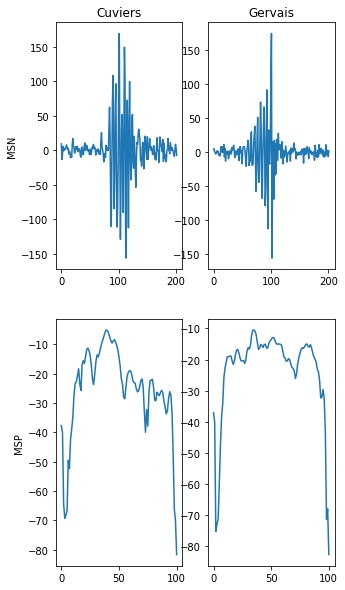

In [191]:
msn_1 = data_psdf.iloc[0]["MSN"]

plt.figure(figsize=(5,10))

# Cuviers
plt.subplot(2, 2, 1)
plt.plot(data_psdf.iloc[0]["MSN"])
plt.title("Cuviers")
plt.ylabel("MSN")

plt.subplot(2,2,3)
plt.plot(data_psdf.iloc[0]["MSP"])
plt.ylabel("MSP")

# Gervais
plt.subplot(2,2,2)
plt.plot(df_gervais.iloc[0]["MSN"])
plt.title("Gervais")

plt.subplot(2,2,4)
plt.plot(df_gervais.iloc[0]["MSP"])

In [194]:
from pyspark.ml.functions import array_to_vector
# => sql df to use sparkML functions
data_sqldf = data_psdf.to_spark()

# Converts MSP column of array of numeric type into a column of pyspark.ml.linalg.DenseVector instances
data_sqldf = data_sqldf.withColumn("features", array_to_vector('MSP').alias('features'))

data_psdf = data_sqldf.to_pandas_on_spark()
data_psdf.head(3)

/home/zenbook/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
22/04/08 11:30:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:30:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:30:53 WARN TaskSetManager: Stage 37 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,MSN,MSP,rec_no,features
0,1,50.2422,"[9.3197, -13.5086, -6.1229, 5.5962, -0.8494, 1...","[-37.7052, -40.2157, -64.4694, -69.3526, -68.2...",01,"[-37.7052, -40.2157, -64.4694, -69.3526, -68.2..."
1,1,55.0377,"[-2.2228, 6.5712, -14.2926, 8.2005, -1.0006, 2...","[-34.7333, -37.8125, -76.5551, -63.8601, -63.2...",01,"[-34.7333, -37.8125, -76.5551, -63.8601, -63.2..."
2,1,44.9439,"[5.8497, 0.9312, -1.3678, -1.0723, -4.6082, 0....","[-39.6219, -42.9117, -70.0049, -80.345, -82.53...",01,"[-39.6219, -42.9117, -70.0049, -80.345, -82.53..."


## Split train-test set

In [196]:
data_train_sqldf, data_test_sqldf =  data_sqldf.randomSplit([0.7,0.3], seed=7777)

## Dimensionality reduction

PCA is selected because Linear Discriminant Analysis is not avaible on SparkML

### Searching for 90% explained variance

In [197]:
from pyspark.ml.feature import PCA

pca = PCA(k=40, inputCol="features", outputCol="pca_features")

model_pca_tuning = pca.fit(data_train_sqldf)


22/04/08 11:31:58 WARN TaskSetManager: Stage 39 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:31:58 WARN TaskSetManager: Stage 40 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:31:58 WARN TaskSetManager: Stage 41 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:31:59 WARN TaskSetManager: Stage 42 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:31:59 WARN TaskSetManager: Stage 43 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


Explained variance:

Text(0, 0.5, 'Explained Variance')

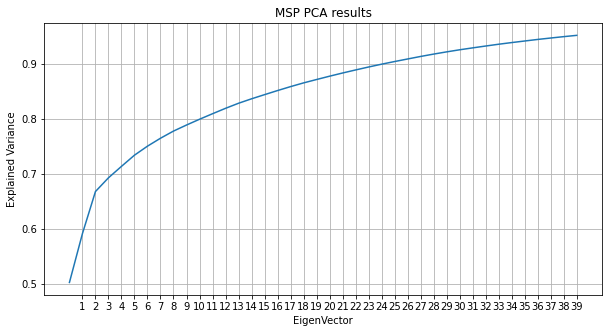

In [198]:
explain_var = model_pca_tuning.explainedVariance
explain_var.toArray().cumsum()

plt.figure(figsize=(10,5))

plt.plot(explain_var.toArray().cumsum())
plt.xticks(np.arange(1, 40, 1))
plt.grid()
plt.title("MSP PCA results")
plt.xlabel("EigenVector")
plt.ylabel("Explained Variance")

25 eigen-vectors explain 90% of the total data variance.

In [199]:
pca = PCA(k=25, inputCol="features", outputCol="pca_features")
model_pca = pca.fit(data_train_sqldf)

# project train and test set
data_train_proj_sqldf = model_pca.transform(data_train_sqldf)

data_test_proj_sqldf = model_pca.transform(data_test_sqldf)


22/04/08 11:32:17 WARN TaskSetManager: Stage 44 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:32:17 WARN TaskSetManager: Stage 45 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:32:17 WARN TaskSetManager: Stage 46 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:32:17 WARN TaskSetManager: Stage 47 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:32:17 WARN TaskSetManager: Stage 48 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


### format parameters

In [200]:
from pyspark.ml.functions import vector_to_array

# Train set
data_train_sqldf = data_train_proj_sqldf.withColumn("eigen_vec", vector_to_array("pca_features").alias("eigen_vec")).select(
    ['label', 'peak_to_peak', 'eigen_vec'])

data_train_psdf = data_train_sqldf.to_pandas_on_spark()

# Test set
data_test_sqldf = data_test_proj_sqldf.withColumn("eigen_vec", vector_to_array("pca_features").alias("eigen_vec")).select(
    ['label', 'peak_to_peak', 'eigen_vec'])

data_test_psdf = data_test_sqldf.to_pandas_on_spark()
data_test_psdf.head(3)

22/04/08 11:34:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:34:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:34:55 WARN TaskSetManager: Stage 49 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,eigen_vec
0,0,42.9310,"[269.70786869795865, 21.97321142563139, -130.6..."
1,0,43.8356,"[281.5754915905967, 2.3622950302401047, -166.4..."
2,0,44.3087,"[238.1310290243969, -45.268299294196005, -143...."


In [201]:
# Select 90% of variance => 25 EV
ev_size = 25

# Train set
for count_ev in range(0, ev_size, 1):
    ev_name = "ev"+ str(count_ev+1)
    data_train_psdf[ev_name] = data_train_psdf["eigen_vec"].apply(lambda row: row[count_ev])

# Test Set
for count_ev in range(0, ev_size, 1):
    ev_name = "ev"+ str(count_ev+1)
    data_test_psdf[ev_name] = data_test_psdf["eigen_vec"].apply(lambda row: row[count_ev])

22/04/08 11:35:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:35:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:35:49 WARN TaskSetManager: Stage 51 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:35:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:35:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:35:49 WARN TaskSetManager: Stage 53 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:35:50 WARN WindowExec: No Partition Defined 

In [202]:
# Train set
data_train_psdf = data_train_psdf.drop(columns=["eigen_vec"])
data_train_psdf.head(3)

# Test set
data_test_psdf = data_test_psdf.drop(columns=["eigen_vec"])
data_test_psdf.head(3)

22/04/08 11:36:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:36:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:36:44 WARN TaskSetManager: Stage 151 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.


,label,peak_to_peak,ev1,ev2,ev3,ev4,ev5,ev6,ev7,ev8,ev9,ev10,ev11,ev12,ev13,ev14,ev15,ev16,ev17,ev18,ev19,ev20,ev21,ev22,ev23,ev24,ev25
0,0,42.9310,269.707869,21.973211,-130.619049,-6.025106,-66.471364,-20.253797,-6.512674,62.833550,6.378976,65.517076,-6.747170,-21.942365,37.608008,31.114854,-6.312037,42.068004,8.072807,6.627279,51.801026,-10.291164,-41.956466,6.432817,-18.187523,16.889789,-6.321797
1,0,43.8356,281.575492,2.362295,-166.453570,-26.934183,-69.325019,-14.921883,-19.783586,42.619014,-0.033539,48.198390,1.057042,-31.705146,33.863027,25.776223,-1.882554,25.057306,-2.148195,-0.490475,49.408084,-4.035308,-33.144337,2.971896,-14.263330,20.495730,4.527657
2,0,44.3087,238.131029,-45.268299,-143.251777,-5.620829,-61.600287,-21.701013,-16.578181,39.913088,18.446981,49.093912,-9.168660,-4.637588,10.726083,25.926831,-4.535915,35.049940,12.273688,7.367830,46.421948,-3.252508,-31.867615,-1.220595,-10.048331,23.969918,-4.863882


## XGBoost Trees

In [203]:
df_data_train = data_train_psdf.to_pandas()
df_data_test = data_test_psdf.to_pandas()
df_data_train.head(5)

22/04/08 11:37:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:37:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:37:36 WARN TaskSetManager: Stage 153 contains a task of very large size (5223 KiB). The maximum recommended task size is 1000 KiB.
22/04/08 11:37:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:37:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:37:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/08 11:37:36 WARN TaskSetMa

,label,peak_to_peak,ev1,ev2,ev3,ev4,ev5,ev6,ev7,ev8,...,ev16,ev17,ev18,ev19,ev20,ev21,ev22,ev23,ev24,ev25
0,0,42.4443,249.551431,-47.256017,-147.644277,-42.211796,-63.682228,0.147929,-17.307211,57.883565,...,37.232507,-4.278431,2.844037,47.781560,-20.214922,-27.575490,4.449203,-23.672042,17.115680,2.857579
1,0,42.9859,268.514267,-8.636113,-107.553175,-0.024833,-65.560103,-28.192928,-5.854800,47.789809,...,37.477833,-0.907823,5.487961,35.498348,-8.593180,-20.020603,17.058295,-12.006713,26.138335,-3.305112
2,0,43.4820,235.206821,-58.057284,-148.054058,-16.933850,-51.418749,-21.876383,-0.565549,61.477214,...,32.935247,-2.298761,11.543080,65.027969,-15.770486,-27.542016,10.852972,-6.456158,30.235699,-6.768540
3,0,44.0305,277.685854,2.956117,-151.802052,-8.757603,-104.461326,24.748317,-15.643376,31.347640,...,28.624450,5.325504,2.680027,50.726066,-9.174496,-36.026054,6.741284,-11.790201,29.690637,-4.330127
4,0,44.0547,245.303185,-62.566615,-142.375085,-16.666241,-83.806378,-6.296950,-18.453531,53.663011,...,22.695371,16.341515,16.008347,55.322666,7.383263,-24.854095,15.831028,-15.803736,27.509111,1.716264


In [207]:
X_train = df_data_train[['peak_to_peak', 'ev1', 'ev2', 'ev3', 'ev4', 'ev5', 'ev6',
       'ev7', 'ev8', 'ev9', 'ev10', 'ev11', 'ev12', 'ev13', 'ev14', 'ev15',
       'ev16', 'ev17', 'ev18', 'ev19', 'ev20', 'ev21', 'ev22', 'ev23', 'ev24',
       'ev25']]
y_train = df_data_train["label"]

X_test = df_data_train[['peak_to_peak', 'ev1', 'ev2', 'ev3', 'ev4', 'ev5', 'ev6',
       'ev7', 'ev8', 'ev9', 'ev10', 'ev11', 'ev12', 'ev13', 'ev14', 'ev15',
       'ev16', 'ev17', 'ev18', 'ev19', 'ev20', 'ev21', 'ev22', 'ev23', 'ev24',
       'ev25']]
y_test = df_data_train["label"]


## Tuning Hyperparameters 

In [215]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.2, 0.3, 0.4], # eta
              'max_depth': [2,3,4],
              'eval_metric' : ['auc', 'logloss', 'error'],
              'n_estimators': [100], #number of trees
}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   verbose=0, refit=True)

bst = clf.fit(X_train, y_train)

In [116]:
# convert to XGB matrix
dtrain = xgb.DMatrix(X_train, label=y_train)
# dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [221]:
param = {}
param['max_depth']= 1   # depth of tree
param['eta'] = 0.1      # shrinkage parameter
param['objective'] = 'binary:logistic'
param['nthread'] = 7 # Number of threads used
param['eval_metric'] = ['auc', 'logloss', 'error'] # last metric will be used for the best eval


# param = {   'nthread':4, #when use hyperthread, xgboost may become slower
#             'objective':'binary:logistic',
#             'learning_rate': 0.3, # eta
#             'max_depth': 3,
#             'eval_metric' : ['auc', 'logloss', 'error'],
#             'nthread' : 4
# }

evals_result = {}
print(param)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

{'max_depth': 1, 'eta': 0.1, 'objective': 'binary:logistic', 'nthread': 7, 'eval_metric': ['auc', 'logloss', 'error']}


In [ ]:
# epochs = len(evals_result['train']['error'])
# x_axis = range(0, epochs)
# print(epochs)

# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['error'], label='Train')
# ax.plot(x_axis, evals_result['eval']['error'], label='eval')
# ax.legend()
# plt.ylabel('ERROR')
# plt.title('XGBoost ERROR')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['logloss'], label='Train_logloss')
# ax.plot(x_axis, evals_result['eval']['logloss'], label='Eval_logloss')
# ax.legend()
# plt.ylabel('LogLoss')
# plt.title('XGBoost LogLoss')
# plt.show()

In [222]:
num_round=1000
evals_result = {}
# early_stopping_rounds
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50 ,verbose_eval=False, evals_result=evals_result)
print(f"Best error score: {bst.best_score} on round {bst.best_iteration}. ")

Best error score: 0.167732 on round 187. 


In [209]:
features_map = {'f0' : 'peak_to_peak',
                'f1' : 'Eigen Projection 1', 'f2' : 'Eigen Projection 2',
                'f3' : 'Eigen Projection 3', 'f4' : 'Eigen Projection 4',
                'f5' : 'Eigen Projection 5', 'f6' : 'Eigen Projection 6',
                'f7' : 'Eigen Projection 7', 'f8' : 'Eigen Projection 8',
                'f9' : 'Eigen Projection 9', 'f10' : 'Eigen Projection 10',
                'f11' : 'Eigen Projection 11', 'f12' : 'Eigen Projection 12',
                'f13' : 'Eigen Projection 13', 'f14' : 'Eigen Projection 14',
                'f15' : 'Eigen Projection 15', 'f16' : 'Eigen Projection 16',
                'f17' : 'Eigen Projection 17', 'f18' : 'Eigen Projection 18',
                'f19' : 'Eigen Projection 19', 'f20' : 'Eigen Projection 20',
                'f21' : 'Eigen Projection 21', 'f22' : 'Eigen Projection 22',
                'f23' : 'Eigen Projection 23', 'f24' : 'Eigen Projection 24',
                'f25' : 'Eigen Projection 25'


}

100 Iterations


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 360x360 with 0 Axes>

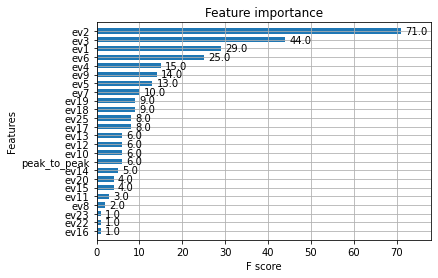

In [210]:
num_round = 100
evals_result = {}
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False, evals_result=evals_result)
print("100 Iterations")

plt.figure(figsize=(5,5))
xgb.plot_importance(bst, grid=True, height=(0.6))

Dummy score on most frequent

In [ ]:
# from sklearn.dummy import DummyClassifier

# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X_train, y_train)

# print(dummy_clf.score(X_val, y_val).round(2))

In [212]:
num_round=1000
# early_stopping_rounds
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50 ,verbose_eval=False, evals_result=evals_result)
print(f"Best error score: {bst.best_score} on round {bst.best_iteration}. ")

Best error score: 0.158147 on round 82. 


In [ ]:
# # early_stopping_rounds
# bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=20 ,verbose_eval=False, evals_result=evals_result)

# y_pred = bst.predict(dtest, output_margin=True)

# from sklearn.metrics import roc_curve
# plt.figure(figsize=(8, 6))
# false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_pred)
# plt.plot(false_pos_rate, true_pos_rate)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title("ROC Curve")
# plt.grid()
# plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# # y_val_pred = bst.predict(dval, iteration_range=(0, bst.best_iteration))
# # print(y_val_pred)

# param = {'nthread':4, #when use hyperthread, xgboost may become slower
#               'learning_rate': 0.1, # eta
#               'max_depth': 5,
#               'alpha' : 10,
#               'colsample_bytree' : 0.3,
#               'n_estimators' : 100,
#               'objective' :'binary:logistic',
#               'eval_metric' : ['auc', 'logloss', 'error'],
#             #   'num_round' : 100,
#                 'use_label_encoder' : False # The use of label encoder in XGBClassifier is deprecated
# }

# num_round = 100
# evals_result = {}

# bst_clf = xgb.XGBClassifier(**param)

# bst_clf = bst_clf.fit(X_train, y_train)

# y_val_pred = bst_clf.predict(X_val)

# y_score = bst_clf.predict_proba(X_test)[:, 1]

# # print(y_test)
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# # y_val_pred = bst.predict(dval, iteration_range=(0, bst.best_iteration))
# # print(y_val_pred)

# param = {'nthread':4, #when use hyperthread, xgboost may become slower
#               'learning_rate': 0.1, # eta
#               'max_depth': 5,
#               'alpha' : 10,
#               'colsample_bytree' : 0.3,
#               'n_estimators' : 100,
#               'objective' :'binary:logistic',
#               'eval_metric' : ['auc', 'logloss', 'error'],
#             #   'num_round' : 100,
#                 'use_label_encoder' : False # The use of label encoder in XGBClassifier is deprecated
# }

# num_round = 100
# evals_result = {}

# bst_clf = xgb.XGBClassifier(**param)

# bst_clf = bst_clf.fit(X_train, y_train)

# y_val_pred = bst_clf.predict(X_val)

# y_score = bst_clf.predict_proba(X_test)[:, 1]

# # print(y_test)

# # bst.predict_proba(ypred_, iteration_range = (0,1))

# print("Val  Accuracy : {accuracy_score(y_val, y_val_pred)}")

# print("\nConfusion Matrix : ")
# print(confusion_matrix(y_val, y_val_pred))

# print("\nClassification Report : ")
# print(classification_report(y_val, y_val_pred))
# # bst.predict_proba(ypred_, iteration_range = (0,1))

# print("Val  Accuracy : {accuracy_score(y_val, y_val_pred)}")

# print("\nConfusion Matrix : ")
# print(confusion_matrix(y_val, y_val_pred))

# print("\nClassification Report : ")
# print(classification_report(y_val, y_val_pred))